<a href="https://colab.research.google.com/github/Axis121/AMLS_assignment22_23/blob/main/B1/B1_Face_Shape_Manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#https://towardsdatascience.com/basic-smile-detection-using-opencv-and-dlib-aeb22afb9e67


In [ ]:
## general imports
import cv2 # manipulating images
import dlib # for face detection
from google.colab.patches import cv2_imshow 
from natsort import natsorted 
import os # to navigate file directories
from os import listdir
import pickle # used to save models

## imports for manipulating and visualising data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2 # test to select most signifacnt features
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

## imports for model building
from sklearn.model_selection import GridSearchCV # cross validation/ grid search for hyper-parameter tuning
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier

## imports for model evaluation
from sklearn import metrics
import seaborn as sns # graphing confusion matrices
from sklearn.model_selection import learning_curve # plot learning curve for a model

##


In [ ]:
def faceLandmarks(im):

    # Path for the detection model
    PREDICTOR_PATH = r"/content/drive/MyDrive/Colab Notebooks/Test_folder/shape_predictor_68_face_landmarks.dat"
    
    # Create object to detect the face
    faceDetector = dlib.get_frontal_face_detector()

    # Create object to detect the facial landmarks
    landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces
    faceRects = faceDetector(im, 0)

    # Initialize landmarksAll array
    landmarksAll = []

    # For each face detected in the image, this chunk of code creates a ROI around the face and pass it as an argument to the 
    # facial landmark detector and append the result to the array landmarks 
    for i in range(0, len(faceRects)):
        newRect = dlib.rectangle(int(faceRects[i].left()),
                            int(faceRects[i].top()),
                            int(faceRects[i].right()),
                            int(faceRects[i].bottom()))
        landmarks = landmarkDetector(im, newRect)
        landmarksAll.append(landmarks)

    return landmarksAll, faceRects


In [ ]:
def renderFacialLandmarks(im, landmarks):
    
    # Convert landmarks into iteratable array
    points = []
    [points.append((p.x, p.y)) for p in landmarks.parts()]

    # Loop through array and draw a circle for each landmark
    for p in points:
        cv2.circle(im, (int(p[0]),int(p[1])), 2, (255,0,0),-1)

    # Return image with facial landmarks 
    return im

Extractions of features

In [1]:
def extractFeatures(folder_dir): 
    number_of_features = 136 # 68 coordinates, x and y points
    features = np.ones((1,number_of_features))*10 #initialise the feature array, row dimension is unknown so rows will be appended eachh time
    current_features = np.zeros((1,number_of_features))

    for images in natsorted(os.listdir(folder_dir)):
    
        # check if the image ends with png
        if (images.endswith(".png")):
            #print(images) # for testing
            ##use images to finish the directory call for im
            ## Read an image to a variable
            im = cv2.imread(folder_dir +"/" + images)
            
            # Get landmarks using the function created above
            landmarks, _ = faceLandmarks(im)

            if len(landmarks) == 0: #set image row to 0 if no face detected
                current_features [0,:]=0
            else:
                # Render the landmarks on the first face detected. You can specify the face by passing the desired index to the landmarks array.
                # In this case, one face was detected, so I'm passing landmarks[0] as the argument.
                faceWithLandmarks = renderFacialLandmarks(im, landmarks[0])
                for j in range(68):
                  #print(j)
                  current_features [0,j]=landmarks[0].parts()[0].x-landmarks[0].parts()[j].x
                  current_features [0,j+68]=landmarks[0].parts()[0].y-landmarks[0].parts()[j].y
        features = np.vstack((features,current_features))
    
    features = np.delete(features,0,axis = 0)
    return features
    print("done")
            

In [ ]:
def getLabel(label_dir,column):
  df = pd.read_csv(label_dir)

  ## replace "-1" labels with a "0", not used in multiclass problems
  df = df.replace(-1,0)
  labels = df.iloc[:,column].values #face shape is the 3rd coloumn, eye colour is the 2nd
  labels = np.transpose(labels)

  return labels

In [ ]:
def removeMissingValues (features, labels):

  featuresAndLabels = np.column_stack((features,labels)) # combine the features and labels into one matrix, horizontally
  featuresAndLabels = featuresAndLabels[~np.all(featuresAndLabels[:,:136] == 0, axis=1)] #remove rows if the feature row section is full of zeroes
  clean_features = featuresAndLabels [:,:136] # remake feature matrix
  clean_labels = featuresAndLabels [:,136] # remake label vector

  return clean_features, clean_labels

In [ ]:
## initial extraction of features
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/cartoon_set/img" # training + validation iamges
features = extractFeatures(folder_dir)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B1/cartoon_feature_test_set.npy",features)

Loading saved features and importing labels

In [ ]:
features = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B1/feature_backup_2.npy")

In [ ]:
## obtaining labels
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/cartoon_set/labels_modified.csv' # training set labels
labels = getLabel(label_dir,column = 2) # get label vector

Dataset Pre-Processing Stage


In [ ]:
clean_features, clean_labels = removeMissingValues (features, labels) # remove image rows with missing values

Graph features and lables // only works for bianry classification. Think of how to adapt or remove

Feature selection using select k best and chi test

In [ ]:
kBest = 60
selected_features = SelectKBest(chi2, k=kBest).fit_transform(abs(clean_features), clean_labels) # choose 30 best features based on chi test, no guideline found for rbf svm but 30 is max for linear svm
# Find indices of chosen feature columns
selector = SelectKBest(chi2,k=kBest).fit(abs(clean_features), clean_labels)
mask = selector.get_support()  # Get boolean mask of selected features
selected_indices = np.where(mask)[0]  # Convert mask to indices # to be used later to extract relevant feature colums from test set

Visualisation of Data

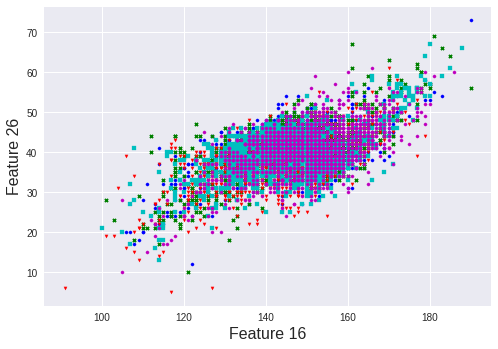

In [ ]:
## plot features against each other with points coloured based on label
## separet data into an array for each unique class

indices = np.where(clean_labels[:] == 0)
class_0 = selected_features [indices,:]

indices = np.where(clean_labels[:] == 1)
class_1 = selected_features [indices,:]

indices = np.where(clean_labels[:] == 2)
class_2 = selected_features [indices,:]

indices = np.where(clean_labels[:] == 3)
class_3 = selected_features [indices,:]

indices = np.where(clean_labels[:] == 4)
class_4 = selected_features [indices,:]

fig = plt.figure()
ax1 = fig.add_subplot(111)

## control which features are plotted against each other
## can vary variable value from 0 to 15 (inclusive) to obtain different plot
feature1 = 16 # feature of x axis
feature2 = 26 # feature of y axis

ax1.scatter(class_0[0,:,feature1], class_0[0,:,feature2], s=10, c='b', marker="o")
ax1.scatter(class_1[0,:,feature1], class_1[0,:,feature2], s=10, c='g', marker="x")
ax1.scatter(class_2[0,:,feature1], class_2[0,:,feature2], s=10, c='r', marker="v")
ax1.scatter(class_3[0,:,feature1], class_3[0,:,feature2], s=10, c='c', marker="s")
ax1.scatter(class_4[0,:,feature1], class_4[0,:,feature2], s=10, c='m', marker="o")

plt.xlabel("Feature "+ str(feature1),fontsize=16)
plt.ylabel("Feature "+ str(feature2),fontsize=16)
plt.show()

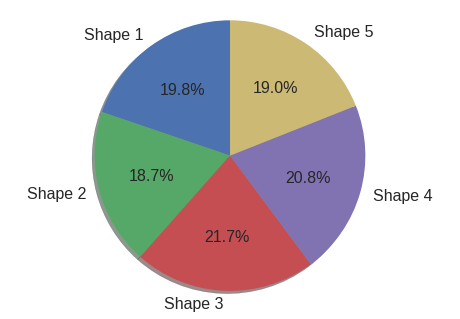

In [ ]:
## Pie Chart Visualisation
unique, counts = np.unique(clean_labels, return_counts=True) # get population numbers for each class

labels = 'Shape 1', 'Shape 2', 'Shape 3', 'Shape 4', 'Shape 5'
sizes = counts
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Splitting processed data into training and validation image sets.

In [ ]:
X_train, X_validate, Y_train, Y_validate = train_test_split(selected_features, clean_labels, test_size=0.3,random_state=109) # 70% training and 30% test

Obtain test set from separate directory of images

In [ ]:
##make a check to see if load file exists then reload, if it does not exist then extract.

In [ ]:
## Extract Features
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/cartoon_set_test/img" # test set
features = extractFeatures(folder_dir)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B1/cartoon_feature_test_set.npy",features) # saving features to a file

In [ ]:
## reload features from saved file and get labels
features_test = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B1/cartoon_feature_test_set.npy")

## labels
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/cartoon_set_test/modified_labels.csv' # test set labels
labels_test = getLabel(label_dir,2) # get label vector

Process Data

In [ ]:
## Match naming convention
X_test = abs(features_test[:,selected_indices]) # features should be positive
Y_test = labels_test

Building Machine Learning Models: Training, Validation and Testing

In [ ]:
## scaling/normalising feature matrices of each set
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)  
X_test_s = scaler.transform(X_test)
X_validate_s = scaler.transform(X_validate)

Logistic Regression

In [ ]:
## Quick test of performance to decide whether it could be promising or not
logr_model = LogisticRegression(max_iter = 200).fit(X_train, Y_train)
preds = logr_model.predict(X_validate)
print(metrics.classification_report(preds, Y_validate))
metrics.confusion_matrix(Y_validate,preds)

              precision    recall  f1-score   support

         0.0       0.51      0.60      0.55       428
         1.0       0.30      0.54      0.39       277
         2.0       0.72      0.35      0.47      1030
         3.0       0.40      0.55      0.46       367
         4.0       0.50      0.63      0.55       398

    accuracy                           0.49      2500
   macro avg       0.49      0.53      0.49      2500
weighted avg       0.56      0.49      0.49      2500



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[257,  28, 142,  23,  50],
       [ 84, 150, 178,  42,  46],
       [ 19,  22, 360,  79,  20],
       [ 28,  56, 182, 201,  33],
       [ 40,  21, 168,  22, 249]])

SVM (RBF)

In [ ]:
## Tuning hyper parameters of svm rbf model using validation set

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train_s, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.220 total time=   6.8s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.219 total time=   4.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.219 total time=   4.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.219 total time=   4.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.219 total time=   4.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.496 total time=   4.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.471 total time=   3.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.512 total time=   3.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.509 total time=   3.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.488 total time=   3.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.497 total time=   3.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.001)


In [ ]:
## Validation ## should evaluate with test set
grid_predictions = grid.predict(X_validate_s)

# print classification report
print(metrics.classification_report(Y_validate, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.70      0.73      0.72       483
         1.0       0.69      0.55      0.61       452
         2.0       0.65      0.74      0.69       508
         3.0       0.67      0.64      0.65       503
         4.0       0.70      0.73      0.72       450

    accuracy                           0.68      2396
   macro avg       0.68      0.68      0.68      2396
weighted avg       0.68      0.68      0.68      2396



In [ ]:
## training tuned model based on training set
# {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

#Create a svm Classifier
rbf_svm_model = svm.SVC(decision_function_shape='ovo',kernel='rbf',C=1000, gamma=0.001) #

#Train the model using the training sets
rbf_svm_model.fit(X_train_s, Y_train)

SVC(C=100, decision_function_shape='ovo', gamma=0.0001)

In [ ]:
#Predict the response for test dataset
y_pred = rbf_svm_model.predict(X_test_s)

print(metrics.classification_report(y_pred, Y_test))
metrics.confusion_matrix(Y_test,y_pred)
cm_svm = metrics.confusion_matrix(Y_test,y_pred) # stored to be used to graph confusion matrix for report

              precision    recall  f1-score   support

         0.0       0.49      0.60      0.54       406
         1.0       0.28      0.59      0.38       236
         2.0       0.79      0.37      0.50      1082
         3.0       0.48      0.61      0.54       396
         4.0       0.47      0.62      0.53       380

    accuracy                           0.50      2500
   macro avg       0.50      0.56      0.50      2500
weighted avg       0.60      0.50      0.51      2500



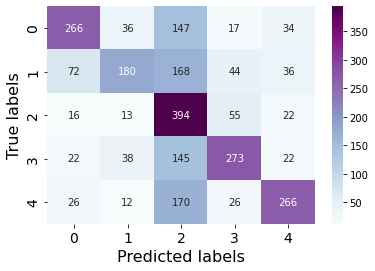

In [ ]:
## Creating confusion matrix plot
ax= plt.subplot()
sns.heatmap(cm_svm, annot=True, fmt='g', ax=ax, cmap="BuPu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 16);ax.set_ylabel('True labels', fontsize = 16);  
font_size = 14 # Adjust as appropriate.
ax.tick_params(labelsize=font_size)
ax.xaxis.set_ticklabels(['0', '1', "2", "3", "4"]); ax.yaxis.set_ticklabels(['0', '1', "2", "3", "4"]); # x axis = 0, 1 | y axis = 0,1

Save the model to be reloaded later

In [ ]:
# save the model to disk
filename = 'B1_svm_model.sav'
pickle.dump(rbf_svm_model, open(filename, 'wb'))

In [ ]:
# load the model from disk
filename = 'B1_svm_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
## Test loaded model
result = loaded_model.score(X_test, Y_test)
print(result)

Examination of Learning Curve

In [ ]:
#rebuild untrained model that achieved highest performance
estimator = svm.SVC(decision_function_shape='ovo',kernel='rbf',C=100, gamma=0.0001)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, selected_features, clean_labels, cv = 5, return_times=True)

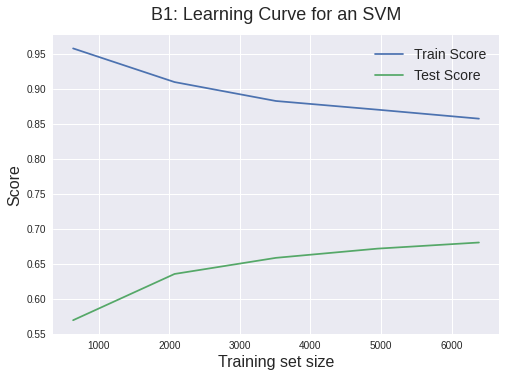

In [ ]:
## plotting learning curve
plt.style.use('seaborn')
plt.plot(train_sizes,np.mean(train_scores,axis=1))
plt.plot(train_sizes,np.mean(test_scores,axis=1))
plt.ylabel('Score', fontsize = 16)
plt.xlabel('Training set size', fontsize = 16)
plt.title('B1: Learning Curve for an SVM', fontsize = 18, y = 1.03)
plt.legend(["Train Score", "Test Score"],prop={'size': 14})
plt.show()